# 导入数据及转为array形式

In [1]:
import pandas as pd
import numpy as np

LassoClassificationFeature = pd.read_excel('./data/分类数据集.xlsx')
RandomForestLogisticsFeature = pd.read_excel('./data/回归数据集.xlsx')

tempArray_Lasso = np.array(LassoClassificationFeature)
tempArray_RandomForest = np.array(RandomForestLogisticsFeature)



# 半监督学习——分类

In [3]:
# coding:utf-8
import random
import numpy as np
import sklearn.svm as svm
from sklearn.datasets.samples_generator import make_classification
from sklearn.externals import joblib
import warnings; warnings.filterwarnings(action='ignore')

class TSVM(object):
    def __init__(self, kernel='linear'):
        self.Cl, self.Cu = 1.5, 0.001
        self.kernel = kernel
        self.clf = svm.SVC(C=1.5, kernel=self.kernel)

    def train(self, X1, Y1, X2):
        N = len(X1) + len(X2)
        # 样本权值初始化
        sample_weight = np.ones(N)
        sample_weight[len(X1):] = self.Cu

        # 用已标注部分训练出一个初始SVM
        self.clf.fit(X1, Y1)
        
        # 对未标记样本进行标记
        Y2 = self.clf.predict(X2)
        Y2 = Y2.reshape(-1,1)
        
        X = np.vstack([X1, X2])
        Y = np.vstack([Y1, Y2])
        
        # 未标记样本的序号
        Y2_id = np.arange(len(X2))
        
        while self.Cu < self.Cl:
            # 重新训练SVM, 之后再寻找易出错样本不断调整
            self.clf.fit(X, Y, sample_weight=sample_weight)
            while True:
                # print(X2)
                print(type(X2))
                Y2_decision = self.clf.decision_function(X2)   # 参数实例到决策超平面的距离
                Y2 = Y2.reshape(-1)
                print(len(Y2))
                print(Y2_decision)
                epsilon = 1 - Y2 * Y2_decision
                negative_max_id = Y2_id[epsilon==min(epsilon)]

                print(epsilon[negative_max_id][0])
                if epsilon[negative_max_id][0] > 0:
                    # 寻找很可能错误的未标记样本，改变它的标记成其他标记
                    pool = list(set(np.unique(Y1))-set(Y2[negative_max_id]))
                    Y2[negative_max_id] = random.choice(pool)
                    Y2 = Y2.reshape(-1, 1)
                    Y = np.vstack([Y1, Y2])
                    
                    self.clf.fit(X, Y, sample_weight=sample_weight)
                else:
                    break
            self.Cu = min(2*self.Cu, self.Cl)
            sample_weight[len(X1):] = self.Cu

    def score(self, X, Y):
        return self.clf.score(X, Y)

    def predict(self, X):
        return self.clf.predict(X)

    def save(self, path='./TSVM.model'):
        joblib.dump(self.clf, path)

    def load(self, model_path='./TSVM.model'):
        self.clf = joblib.load(model_path)

    def plot_confusion_matrix(self, X, Y):
        plot_confusion_matrix(self.clf,X,Y)

if __name__ == '__main__':
    tempArray = np.array(tempArray_Lasso)[:,:]

    #43很好
    split_num = 92

    #18效果还可以25：f1_score: 0.7692307692307692
    test_num = 25

    train_data = tempArray[test_num:split_num,5:]
    train_labels = np.array(np.array(tempArray)[test_num:split_num,4].astype(int)).reshape(-1,1)

    test_data = tempArray[:test_num,5:]
    test_labels = np.array(np.array(tempArray)[:test_num,4].astype(int)).reshape(-1,1)

    X2 = tempArray[split_num:,5:]
    Y2_labeled = np.array(np.array(tempArray)[split_num:,4].astype(int)).reshape(-1,1)

    model = TSVM()
    model.train(train_data, train_labels, X2)

    # Y2_hat = model.predict(X2)
    accuracy = model.score(test_data, test_labels)
    print(accuracy)
    
    pred = np.array(model.predict(test_data)).reshape(-1,1)

<class 'numpy.ndarray'>
46
[ 0.22347202 -0.92038551 -0.5052064  -3.50793109  0.98894961 -1.43996827
  1.29918489 -2.44446651 -0.66406514 -1.62671872 -3.8271347  -0.55194847
 -2.4060334  -1.10855959  1.03605312  4.04300685  0.00791735  0.43416164
 -1.25290907  0.87788098  1.1354146  -0.71589415 -0.23610922 -1.0681112
 -0.23672229 -0.40779877 -1.57817398 -1.91850113 -1.69464119 -4.77376236
 -1.787224   -1.74306764  0.08222825 -0.04381862  0.05447697 -1.96870947
  0.55548661 -1.58895646 -0.76496652 -0.03863266 -1.36009382 -0.62224519
  0.2969164  -2.21054324 -0.05537788 -1.90287054]
-3.0430068486119746
<class 'numpy.ndarray'>
46
[ 2.25939037e-01 -9.23644711e-01 -5.06357837e-01 -3.51335068e+00
  9.87271799e-01 -1.44255858e+00  1.30119816e+00 -2.44669160e+00
 -6.69254761e-01 -1.63000856e+00 -3.83099892e+00 -5.52145729e-01
 -2.40794130e+00 -1.10973463e+00  1.03486563e+00  4.04804747e+00
  4.73124811e-03  4.36107935e-01 -1.25482889e+00  8.75248325e-01
  1.13528119e+00 -7.14364108e-01 -2.37772

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# print(test_labels)
# print(pred)

print("accuracy_score:",precision_score(test_labels, pred))
print("precision_score:",precision_score(test_labels, pred))
print("recall_score:",recall_score(test_labels, pred))
print("f1_score:",f1_score(test_labels, pred))

accuracy_score: 0.8333333333333334
precision_score: 0.8333333333333334
recall_score: 0.7142857142857143
f1_score: 0.7692307692307692


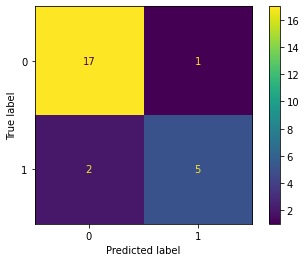

In [211]:
model.plot_confusion_matrix(test_data,test_labels)

# 半监督学习——回归任务

In [279]:
import numpy as np
import random
from sklearn.metrics import *
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.semi_supervised import LabelPropagation
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


tempArray = np.array(tempArray_Lasso)[:,:]
print(len(tempArray))
data = tempArray[:,5:]

labels = np.array(tempArray)[:,3].astype(int)


split_num = 19

train_data = tempArray[split_num:,5:]
# np.save('X.npy',data)
# np.save('y.npy',labels)
train_labels = np.array(tempArray)[split_num:,3].astype(int)

# print(data)
masked_labels = np.array(tempArray)[:,3].astype(int)

# train_X,test_X,train_y,test_y = train_test_split(data,labels,test_size=0.2,random_state=4)

#RUN THE MODEL
model = LabelPropagation()
# model.fit(train_X, train_y)
model.fit(train_data,train_labels)
pred = np.array(model.predict(data))

# print(labels[masked_labels] == -1)

#SEPARATE PREDICTED SAMPLES
# labels = np.array(labels[masked_labels != -1]).astype(int)
# pred = pred[masked_labels != -1]

labels = np.array(tempArray)[:split_num,3].astype(int)
pred = pred[0:split_num]

print(len(pred))
print(labels)
print(pred)

print('Mean squared error: %.2f'
    % mean_squared_error(labels, pred))
print('Coefficient of determination: %.2f'
    % r2_score(labels, pred))


138
19
[18 16 16 20 13 15 11 17 25 22 17 17 16 17 16  8 18 15  8]
[19 12 18 20 10 11  7 21 16 25 12 12 16 11 21 12 15 15 12]
Mean squared error: 16.84
Coefficient of determination: -0.04
